In [1]:
import zarrdataset as zds
import zarr

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = ["https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.4/idr0073A/9798462.zarr"]

In [3]:
import random
import numpy as np

# For reproducibility
np.random.seed(478963)
random.seed(478965)

In [4]:
z_img = zarr.open(filenames[0], mode="r")
z_img["0"].info

Name,/0
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 16433, 21115)"
Chunk shape,"(1, 1, 1, 1024, 1024)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,1040948385 (992.7M)
Chunks initialized,0/1071


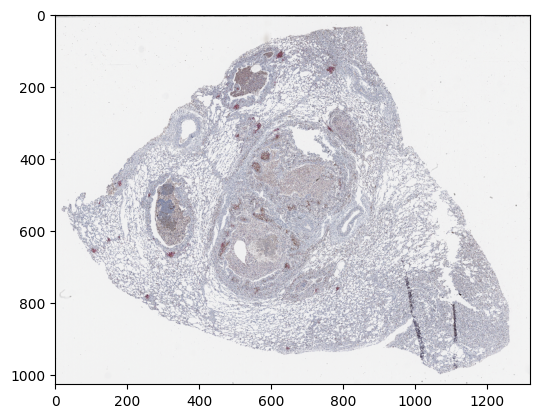

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.moveaxis(z_img["4"][0, :, 0], 0, -1))
plt.show()

In [6]:
from skimage import color, filters, morphology

In [7]:
im_gray = color.rgb2gray(z_img["4"][0, :, 0], channel_axis=0)
thresh = filters.threshold_otsu(im_gray)

mask = im_gray > thresh
mask = morphology.remove_small_objects(mask == 0, min_size=16 ** 2,
                                       connectivity=2)
mask = morphology.remove_small_holes(mask, area_threshold=128)
mask = morphology.binary_erosion(mask, morphology.disk(8))
mask = morphology.binary_dilation(mask, morphology.disk(8))

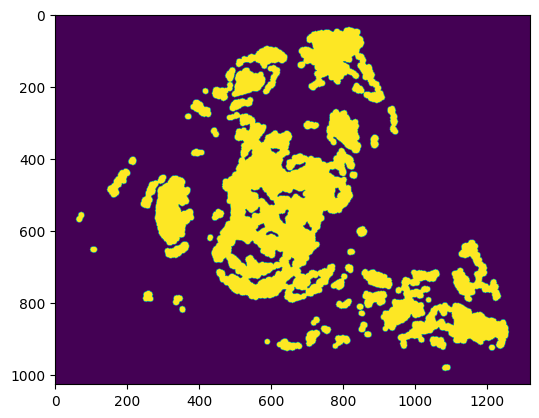

In [8]:
plt.imshow(mask)
plt.show()

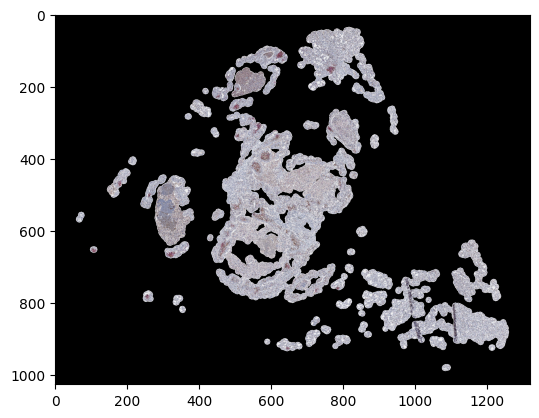

In [9]:
plt.imshow(np.moveaxis(z_img["4"][0, :, 0], 0, -1))
plt.imshow(mask, cmap="gray", alpha=1.0*(mask < 1))
plt.show()

In [10]:
patch_size = dict(Y=512, X=512)
patch_sampler = zds.PatchSampler(patch_size=patch_size)

In [11]:
image_specs = zds.ImagesDatasetSpecs(
  filenames=filenames,
  data_group="1",
  source_axes="TCZYX",
)

# Use the MasksDatasetSpecs to add the specifications of the masks.
#masks_specs = zds.MasksDatasetSpecs(
masks_specs = zds.LabelsDatasetSpecs(
  filenames=[mask],
  source_axes="YX",
  axes="ZYX",
  modality="masks",
)

my_dataset = zds.ZarrDataset([image_specs, masks_specs],
                             patch_sampler=patch_sampler)

In [12]:
ds_iterator = iter(my_dataset)

In [13]:
sample = next(ds_iterator)
type(sample[0]), sample[0].shape, sample[0].dtype
type(sample[1]), sample[1].shape, sample[1].dtype

(numpy.ndarray, (1, 64, 65), dtype('bool'))

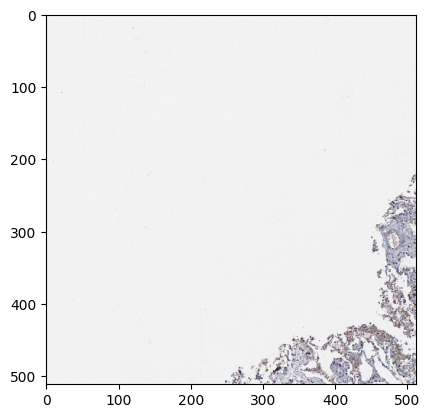

In [14]:
plt.imshow(np.moveaxis(sample[0][0, :, 0], 0, -1))
plt.show()

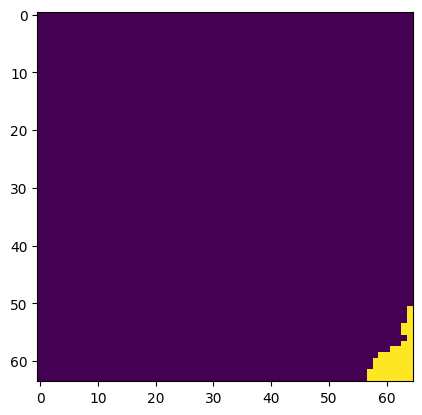

In [15]:
plt.imshow(sample[1][0])
plt.show()

In [16]:
samples = []
labels = []
for i, sample in enumerate(my_dataset):
    samples.append(np.moveaxis(sample[0][0, :, 0], 0, -1))
    labels.append(sample[1][0])

    if i >= 4:
        # Take only five samples for illustration purposes
        break

samples = np.hstack(samples)
labels = np.hstack(labels)

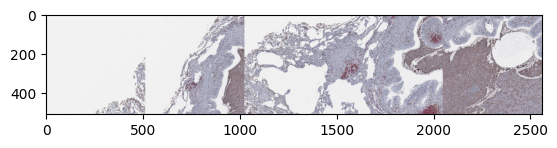

In [17]:
plt.imshow(samples)
plt.show()

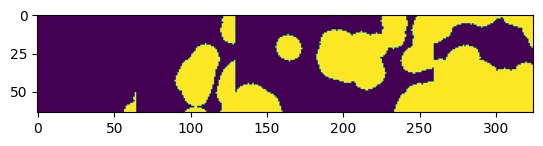

In [18]:
plt.imshow(labels)
plt.show()

In [19]:
patch_size = dict(Y=512, X=512)
patch_sampler = zds.PatchSampler(patch_size=patch_size, min_area=1/16)

In [20]:
mask_func = zds.WSITissueMaskGenerator(mask_scale=1,
                                       min_size=16,
                                       area_threshold=128,
                                       axes="ZYX")

In [21]:
image_specs = zds.ImagesDatasetSpecs(
  filenames=filenames,
  data_group="1",
  source_axes="TCZYX",
)

# Use the MasksDatasetSpecs to add the specifications of the masks.
# The mask generation function is added as `image_loader_func` parameter of the dataset specification for masks.
masks_specs = zds.MasksDatasetSpecs(
  filenames=filenames,
  data_group="4",
  source_axes="TCZYX",
  axes="YXC",
  roi="(0,0,0,0,0):(1,-1,1,-1,-1)",
  image_loader_func=mask_func,
)

my_dataset = zds.ZarrDataset([image_specs, masks_specs],
                             patch_sampler=patch_sampler,
                             shuffle=True)

In [22]:
samples = []

for i, sample in enumerate(my_dataset):
    samples.append(np.moveaxis(sample[0, :, 0], 0, -1))

    if i >= 4:
        # Take only five samples for illustration purposes
        break

samples = np.hstack(samples)

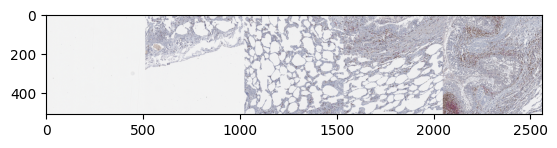

In [23]:
plt.imshow(samples)
plt.show()